In [1]:
import xgboost
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = 'RF_YN_Model3.csv'
df = pd.read_csv(data)
df.head()

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Displ (m),Target
0,0.370809,0.909116,0.319117,5.465739,0.546270,0.000000,0
1,1.300896,1.123009,0.211770,0.905948,0.532398,0.195432,0
2,1.300896,0.847858,0.195947,0.849104,0.532398,0.217259,0
3,1.788212,2.044325,0.115795,0.451034,0.542307,0.239763,0
4,1.637517,2.003797,0.137265,0.941866,0.545784,0.377358,1


In [3]:
#define features matrix (X) and target (y)
X = df.drop(['Displ (m)'], axis = 1)
y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)','Displ (m)'],axis=1)

# implementing train-test-split
X_train_target, X_test_target, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_all = X.drop(['Target'], axis=1)
X_train = X_train_target.drop(['Target'], axis = 1)
X_test = X_test_target.drop(['Target'], axis = 1)


In [4]:
# Classifier fit
model = xgboost.XGBClassifier().fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[17:58:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
# Function to Plot confusion matrix 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Observed',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Accuracy

In [6]:
print('Training score: %.2f%%' %(model.score(X_train, y_train) * 100))
print('Testing score: %.2f%%' %(model.score(X_test, y_test) * 100))
print('Overall score: %.2f%%' %(model.score(X_all, y) * 100))

Training score: 97.62%
Testing score: 84.72%
Overall score: 95.03%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Confusion matrix, without normalization
[[3355   41]
 [  98 2338]]
Normalized confusion matrix
[[0.99 0.01]
 [0.04 0.96]]
Confusion matrix, without normalization
[[746  94]
 [129 490]]
Normalized confusion matrix
[[0.89 0.11]
 [0.21 0.79]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


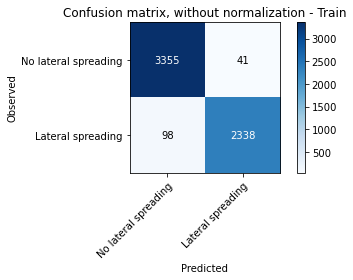

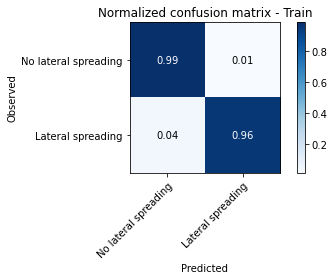

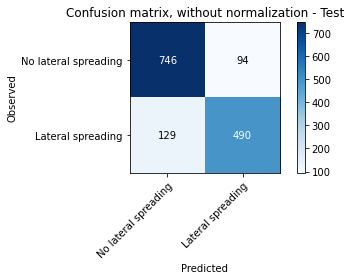

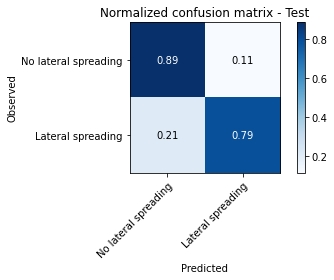

Confusion matrix, without normalization
[[4101  135]
 [ 227 2828]]
Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


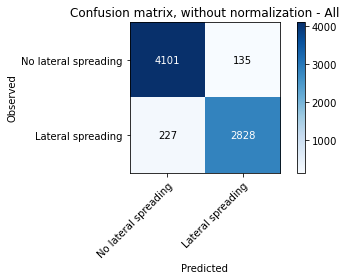

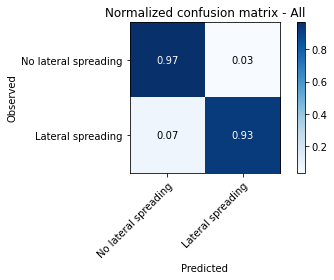

In [7]:
#make prediction
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)
Y_pred_all = model.predict(X_all)

#assign class names
class_names=np.array(['No lateral spreading','Lateral spreading'], dtype='U25')

# Plot non-normalized confusion matrix for training dataset
np.set_printoptions(precision=2)
plot_confusion_matrix(y_train, Y_pred_train, classes=class_names,
                      title='Confusion matrix, without normalization - Train')

# Plot normalized confusion matrix for training dataset
plot_confusion_matrix(y_train, Y_pred_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Train')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix for testing dataset
plot_confusion_matrix(y_test, Y_pred_test, classes=class_names,
                      title='Confusion matrix, without normalization - Test')

# Plot normalized confusion matrix for testing dataset
plot_confusion_matrix(y_test, Y_pred_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Test')
plt.show()


# Plot non-normalized confusion matrix for whole dataset
plot_confusion_matrix(y, Y_pred_all, classes=class_names,
                      title='Confusion matrix, without normalization - All')

# Plot normalized confusion matrix for whole dataset
plot_confusion_matrix(y, Y_pred_all, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - All')
plt.show()

# Local explanations

In [8]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Case of no lateral spreading

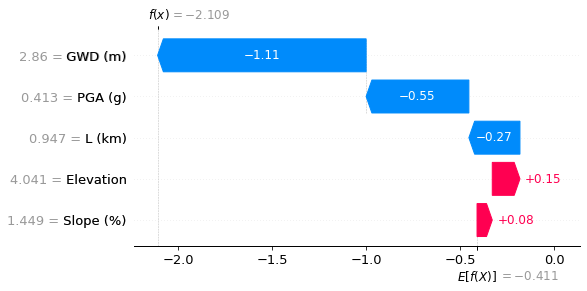

Target    0
Name: 1983, dtype: int64
Sum of SHAP value:  -2.1091635


In [9]:
# visualize no lateral spreading prediction explanation
shap.plots.waterfall(shap_values[0])
print(y_train.iloc[0])

# Sum of individual SHAP values + the mean base value yields the final result
print("Sum of SHAP value: ", np.sum(shap_values[0].values) + shap_values[0].base_values)


In [10]:
# visualize the no lateral spreading prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

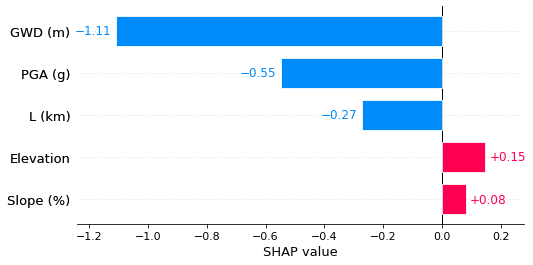

In [11]:
shap.plots.bar(shap_values[0])

## Case of lateral spreading

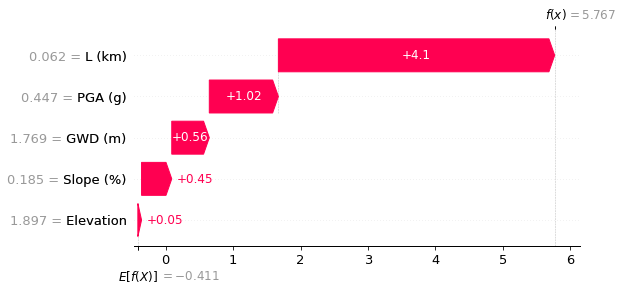

Target    1
Name: 6295, dtype: int64


In [12]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(shap_values[2])
print(y_train.iloc[2])

In [13]:
# visualize lateral spreading explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[2])

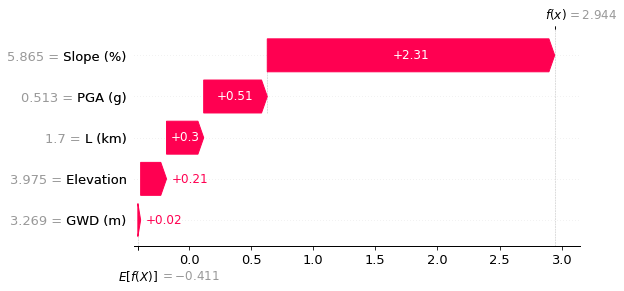

Target    1
Name: 1100, dtype: int64


In [14]:
# visualize lateral spreading prediction's explanation - A case of high slope angle
shap.plots.waterfall(shap_values[3016])
print(y_train.iloc[3016])

# Local explanations (Grouped by Type)

## Accuracy

In [15]:
# make prediction
preds = model.predict(X_test)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.72%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [16]:
# Create a dataframe with errors
test_targets = X_test_target['Target']
error = predictions - test_targets
testdf = pd.concat([X_test_target, pd.DataFrame({'error':error})], axis=1)

### True Positive

In [17]:
# Target = 1 (lateral spreading)
tp = testdf[testdf['error'] == 0]
tp = tp[tp['Target'] == 1]

X_true_pos = tp.drop(['Target', 'error'], axis=1)
tp

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target,error
831,2.032844,2.184585,0.188465,0.356181,0.452941,1,0
641,2.810952,5.397034,1.652887,0.959647,0.492253,1,0
3000,2.102416,4.072007,0.903481,0.396884,0.460277,1,0
233,1.601831,3.278744,0.329205,2.648838,0.443143,1,0
3352,1.694889,3.111853,0.788277,1.098163,0.469252,1,0
...,...,...,...,...,...,...,...
470,2.716594,3.939198,1.033595,2.681163,0.474235,1,0
2828,2.137872,0.000000,1.891575,0.000000,0.411182,1,0
6193,1.185998,1.992755,0.008484,0.898328,0.471589,1,0
3369,1.363289,3.330142,1.090190,0.243576,0.462743,1,0


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


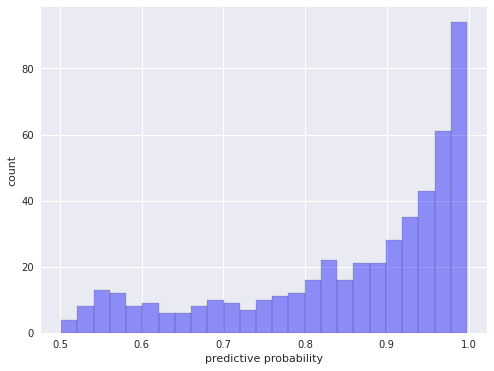

In [18]:
# Prediction probability
prob = model.predict_proba(X_true_pos)
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    sns.distplot(prob[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
    plt.xlabel('predictive probability')
    plt.ylabel('count')

In [19]:
# SHAP values of false positive dataset
tp_shap_values = explainer(X_true_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


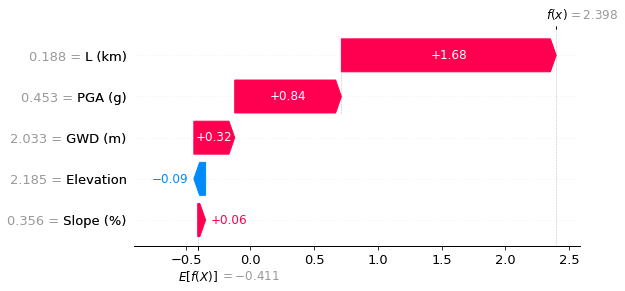

In [20]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(tp_shap_values[0])

#### Large distance (L > 2 km), why do we still predict lateral spreading?

In [21]:
tpfar = tp[tp['L (km)'] > 2]
Xfar = tpfar.drop(['Target', 'error'], axis=1)
tpfar

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target,error
2551,1.661655,0.000000,2.268492,0.000000,0.399452,1,0
4270,1.254269,4.898041,2.206965,0.751614,0.378288,1,0
2797,1.750575,0.000000,2.308057,0.000000,0.401707,1,0
4328,0.850854,3.960492,2.354993,0.534235,0.380259,1,0
3093,1.921273,0.000000,2.444558,0.000000,0.400819,1,0
2839,1.754800,0.000000,2.291791,0.000000,0.401707,1,0
2569,1.690768,0.000000,2.064171,0.000000,0.402578,1,0
2619,1.545700,0.000000,2.052396,0.000000,0.402578,1,0
2707,1.695215,0.000000,2.289310,0.000000,0.401707,1,0
5210,2.251534,5.000974,2.021386,0.960506,0.381165,1,0


In [22]:
# SHAP values of X far dataset
xfar_shap_values = explainer(Xfar)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


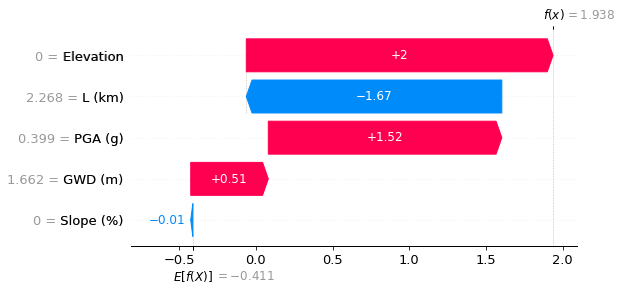

In [23]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(xfar_shap_values[0])

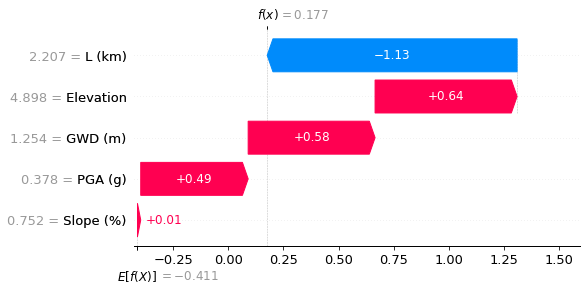

In [24]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(xfar_shap_values[1])

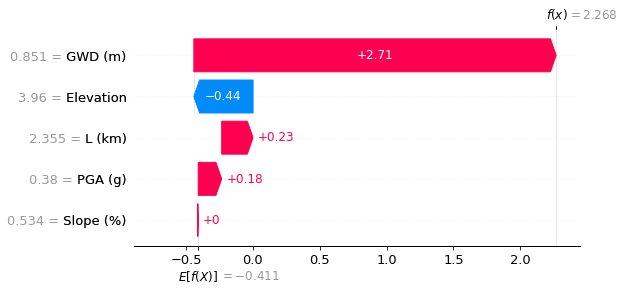

In [25]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(xfar_shap_values[3])

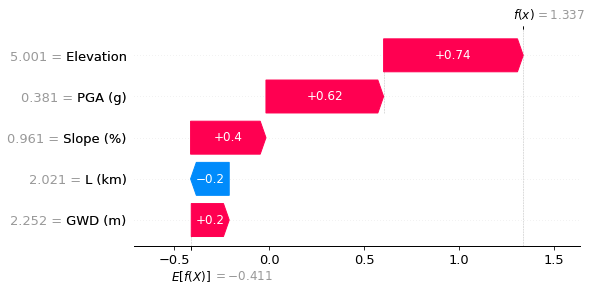

In [26]:
# visualize lateral spreading prediction's explanation, low water table
shap.plots.waterfall(xfar_shap_values[9])

## True Negative

In [27]:
# Target = 0 (no-lateral spreading)
tn = testdf[testdf['error'] == 0]
tn = tn[tn['Target'] == 0]

X_true_neg = tn.drop(['Target', 'error'], axis=1)
tn

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target,error
4721,1.520208,4.535532,1.408396,0.993836,0.406295,0,0
4447,1.295173,4.318707,2.174675,0.375034,0.382730,0,0
2039,2.791280,4.065040,0.810139,1.332437,0.416318,0,0
6486,2.183014,2.166952,0.417520,0.779208,0.454220,0,0
864,1.842521,2.089193,0.336951,0.392722,0.458767,0,0
...,...,...,...,...,...,...,...
1096,4.344453,5.927958,1.857861,3.596380,0.516319,0,0
276,2.785572,2.087179,0.911250,0.606944,0.506586,0,0
401,2.403624,4.883755,1.017401,1.960305,0.490088,0,0
4004,2.953431,3.946183,0.732476,3.012807,0.483830,0,0


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


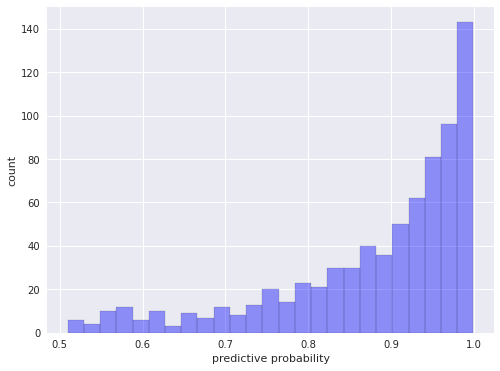

In [28]:
# Prediction probability
prob = model.predict_proba(X_true_neg)
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    sns.distplot(prob[:,0], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
    plt.xlabel('predictive probability')
    plt.ylabel('count')

In [29]:
# SHAP values of X far dataset
tn_shap_values = explainer(X_true_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


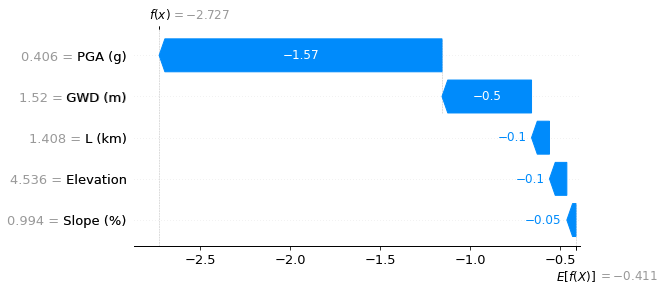

In [30]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(tn_shap_values[0])

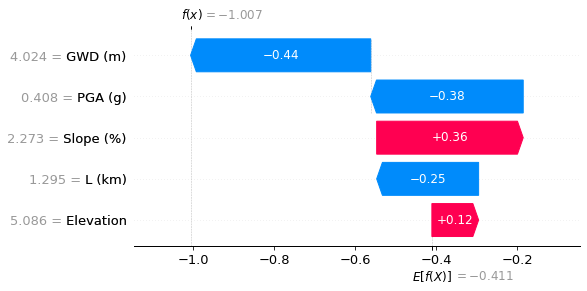

In [31]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(tn_shap_values[41])

### False positive

In [32]:
# Error is 1 means prediction 1 (lateral spreading) while target is 0 (no-lateral spreading)
fp = testdf[testdf['error'] == 1]

X_false_pos = fp.drop(['Target', 'error'], axis=1)
fp

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target,error
3016,2.179170,0.000000,1.956249,0.000000,0.413459,0,1
6511,2.640565,3.118182,0.035327,4.665368,0.424457,0,1
6450,2.354515,2.911323,0.279766,0.436656,0.458489,0,1
3365,2.721586,5.466979,1.239207,5.670625,0.449371,0,1
5708,2.106421,2.734850,0.185466,1.495505,0.442483,0,1
...,...,...,...,...,...,...,...
3083,2.095482,4.537524,1.004010,0.673223,0.453596,0,1
5780,2.314931,2.766711,0.431021,1.982780,0.430679,0,1
7105,2.058659,3.805578,1.753357,5.645064,0.359245,0,1
3171,2.050342,3.381300,0.560812,1.952973,0.470164,0,1


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


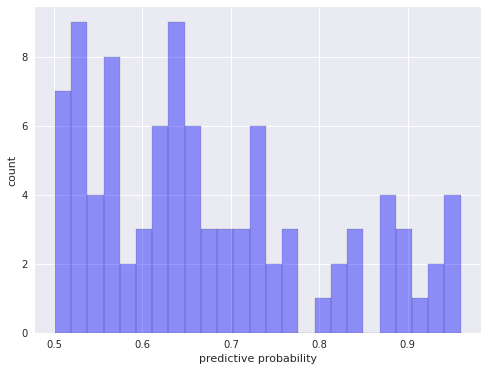

In [33]:
# Prediction probability
prob = model.predict_proba(X_false_pos)
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    sns.distplot(prob[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
    plt.xlabel('predictive probability')
    plt.ylabel('count')

In [34]:
# SHAP values of false positive dataset
fp_shap_values = explainer(X_false_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


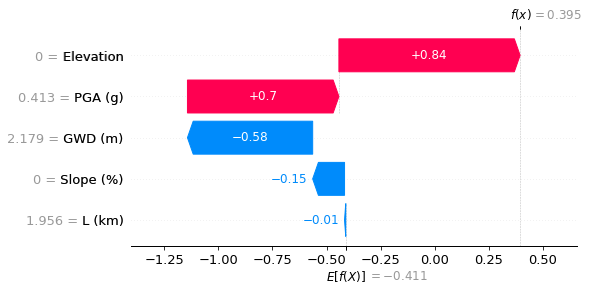

In [35]:
# visualize lateral spreading prediction's explanation - The elevation and slope values are zero
shap.plots.waterfall(fp_shap_values[0])

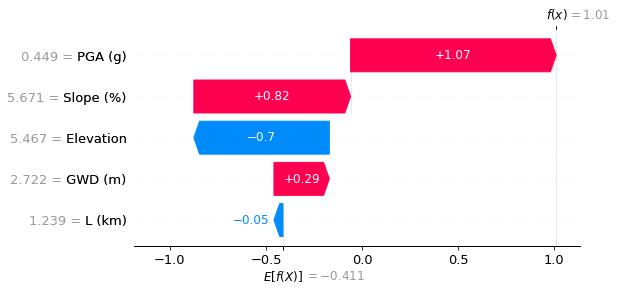

In [36]:
#  The elevation and slope values are large
shap.plots.waterfall(fp_shap_values[3])

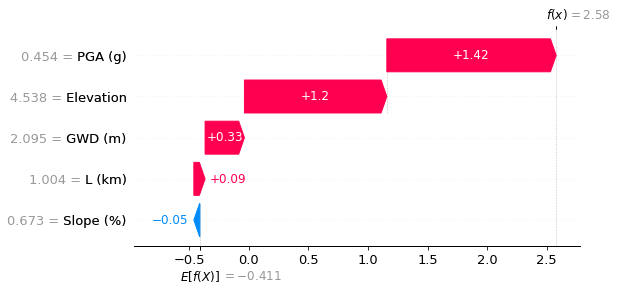

In [37]:
#  High elevation and flat slope values
shap.plots.waterfall(fp_shap_values[89])

**In all false positives, the high PGA is what tripped the model.**

### False negatives

In [38]:
# Error is -1 means prediction 0 (no-lateral spreading) while target is 1 (lateral spreading)
fn = testdf[testdf['error'] == -1]

X_false_neg = fn.drop(['Target', 'error'], axis=1)
fn

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Target,error
6003,1.879269,2.382551,0.010498,3.174181,0.464802,1,-1
6816,1.432532,1.884559,0.515965,0.439989,0.453988,1,-1
4036,1.088380,0.877289,0.220572,0.254102,0.507725,1,-1
533,2.803994,4.605346,1.257001,0.735527,0.480200,1,-1
526,2.818855,5.736539,1.360140,0.557651,0.494229,1,-1
...,...,...,...,...,...,...,...
9,1.482130,1.488147,0.003209,3.220948,0.539283,1,-1
5430,1.896682,3.805564,0.953790,0.202917,0.409164,1,-1
660,1.773657,1.995088,0.365602,0.652486,0.454733,1,-1
2890,1.581852,0.000000,2.008923,0.000000,0.408003,1,-1


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


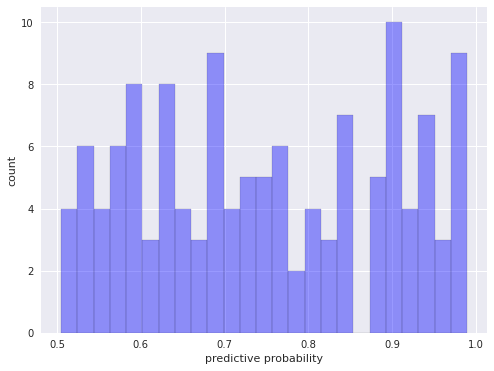

In [39]:
# Prediction probability
prob = model.predict_proba(X_false_neg)
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    sns.distplot(prob[:,0], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
    plt.xlabel('predictive probability')
    plt.ylabel('count')

In [40]:
# SHAP values of false negative dataset
fn_shap_values = explainer(X_false_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


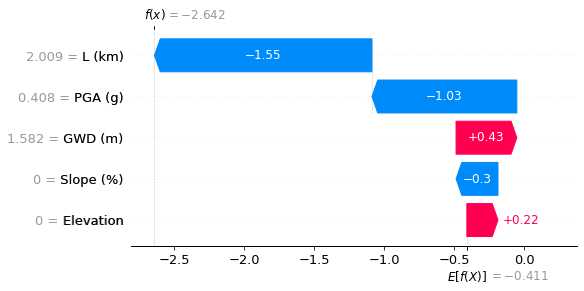

In [41]:
# The elevation and slope values are zero
shap.plots.waterfall(fn_shap_values[127])

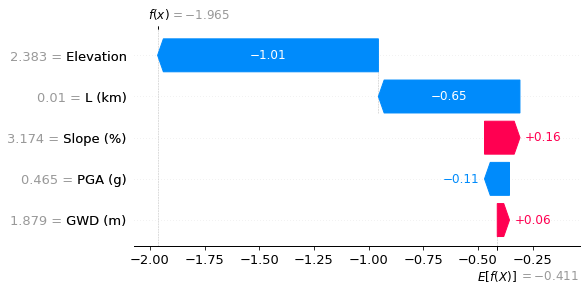

In [42]:
# The elevation and slope values are non-zero
shap.plots.waterfall(fn_shap_values[0])

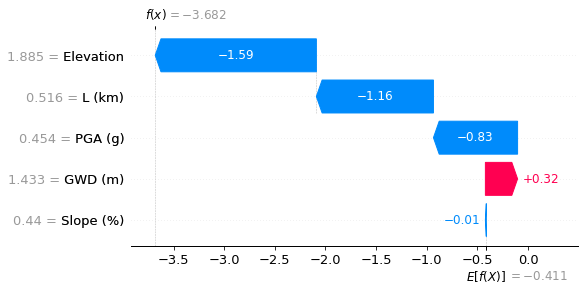

In [43]:
# The elevation and slope values are non-zero
shap.plots.waterfall(fn_shap_values[1])

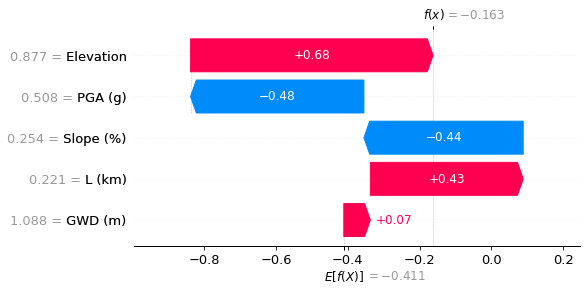

In [44]:
# The elevation and slope values are non-zero
shap.plots.waterfall(fn_shap_values[2])

# Global explanations

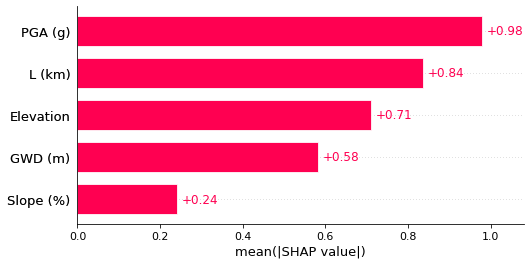

In [45]:
shap.plots.bar(shap_values)

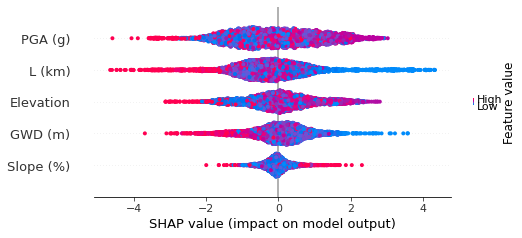

In [46]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

## True Positives

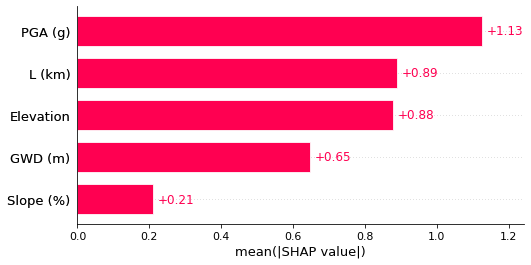

In [47]:
shap.plots.bar(tp_shap_values)

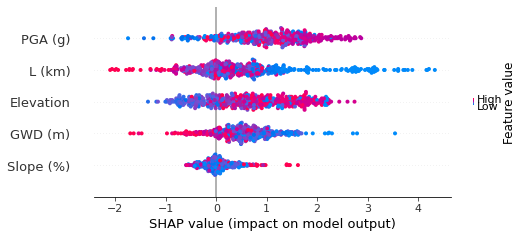

In [48]:
# summarize the effects of all the features
shap.plots.beeswarm(tp_shap_values)

### True negative

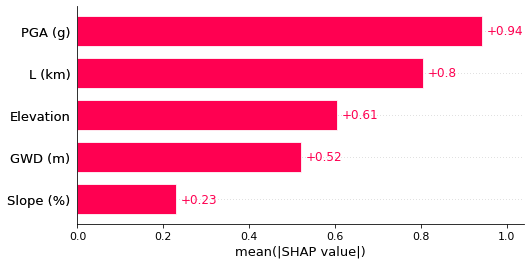

In [49]:
shap.plots.bar(tn_shap_values)

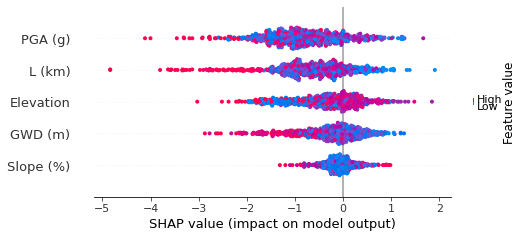

In [50]:
shap.plots.beeswarm(tn_shap_values)

### False positives

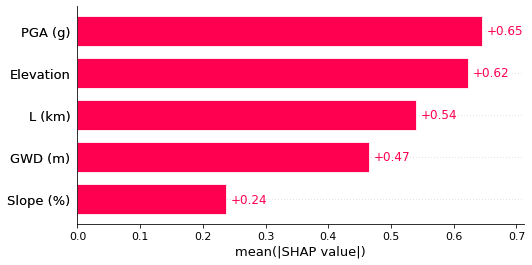

In [51]:
shap.plots.bar(fp_shap_values)

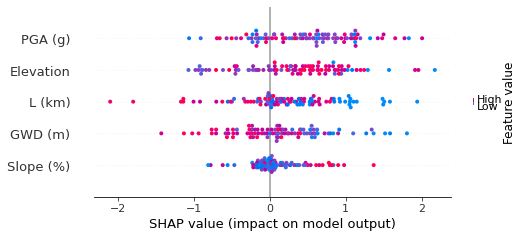

In [52]:
shap.plots.beeswarm(fp_shap_values)

### False Negative

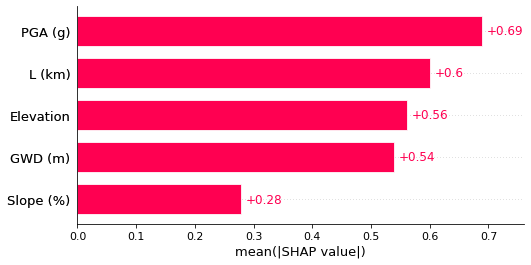

In [53]:
shap.plots.bar(fn_shap_values)

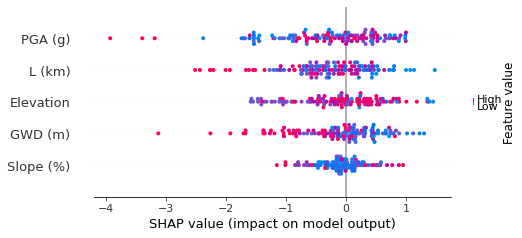

In [54]:
shap.plots.beeswarm(fn_shap_values)

# Feature relations

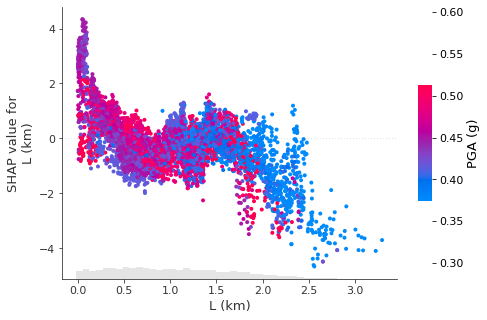

In [55]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"L (km)"], color=shap_values)

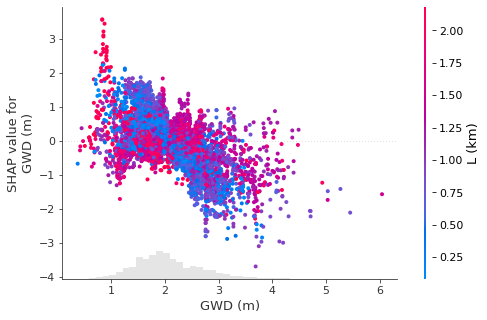

In [56]:
shap.plots.scatter(shap_values[:,"GWD (m)"], color=shap_values)

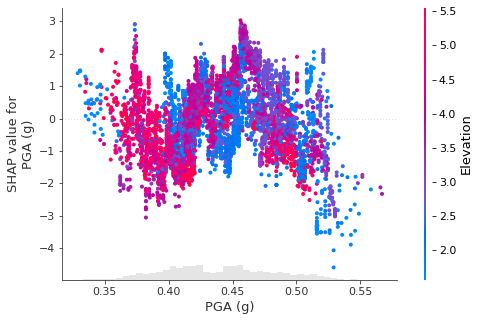

In [57]:
shap.plots.scatter(shap_values[:,"PGA (g)"], color=shap_values)

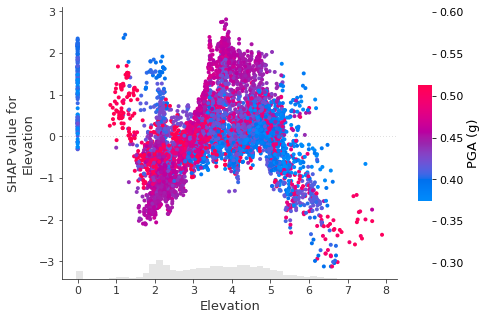

In [58]:
shap.plots.scatter(shap_values[:,"Elevation"], color=shap_values)

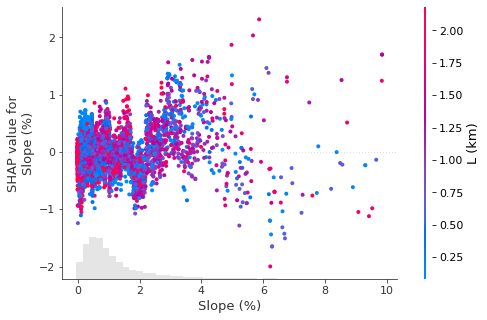

In [59]:
shap.plots.scatter(shap_values[:,"Slope (%)"], color=shap_values)

# Unsupervised clustering

In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster
from sklearn.datasets import make_blobs

import warnings
import sys

print("Python Version : ",sys.version)
print("Scikit-Learn Version : ",sklearn.__version__)

warnings.filterwarnings('ignore') ## We'll silent future warnings using this command.
np.set_printoptions(precision=3)

## Beow magic function fits plot inside of current notebook. 
## There is another option to it (%matplotlib notebook) which opens plot in new notebook.
%matplotlib inline

Python Version :  3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:13:55) 
[Clang 11.1.0 ]
Scikit-Learn Version :  1.0.2


In [61]:
# GWD datset
gwd = shap_values.data[:,0]
gwd_shap = shap_values.values[:,0]
gwd_shap_dataset = np.array(list(zip(gwd, gwd_shap)))
target = X_train_target['Target']

In [62]:
kmeans = cluster.KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_kmeans = kmeans.fit_predict(gwd_shap_dataset)

In [63]:
print('Cluster Centers : \n', str(kmeans.cluster_centers_))

Cluster Centers : 
 [[ 2.89  -0.89 ]
 [ 1.799  0.326]]


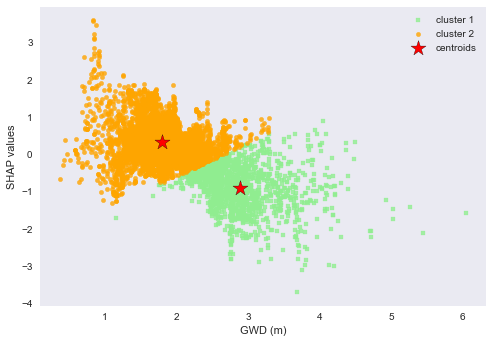

In [64]:
with plt.style.context(('ggplot', 'seaborn')):
    # plot the 2 clusters
    plt.scatter(
        gwd_shap_dataset[y_kmeans == 0, 0], gwd_shap_dataset[y_kmeans == 0, 1],
        s=20, c='lightgreen',
        marker='s', alpha = 0.8,
        label='cluster 1'
    )

    plt.scatter(
        gwd_shap_dataset[y_kmeans == 1, 0], gwd_shap_dataset[y_kmeans == 1, 1],
        s=20, c='orange',
        marker='o', alpha = 0.8,
        label='cluster 2'
    )

    # plot the centroids
    plt.scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
    plt.legend(scatterpoints=1)

    plt.xlabel('GWD (m)')
    plt.ylabel('SHAP values')
    plt.grid()
    plt.show()

### Scatter plot of GWD (m) vs SHAP values

The GWD is the first column of the SHAP values matrix.

In [65]:
# GWD datset
gwd = shap_values.data[:,0]
gwd_shap = shap_values.values[:,0]
gwd_shap_dataset = np.array(list(zip(gwd, gwd_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


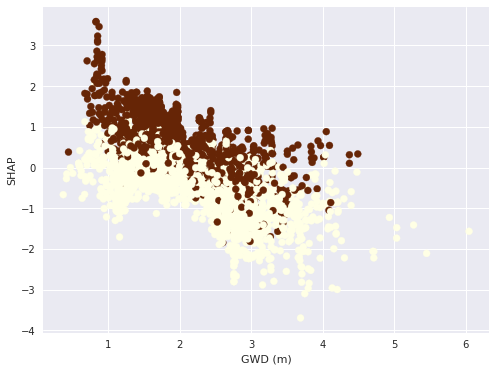

In [66]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(gwd, gwd_shap, c=target, cmap='YlOrBr')

    plt.xlabel('GWD (m)')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

### Distance to river

In [67]:
# GWD datset
l = shap_values.data[:,2]
l_shap = shap_values.values[:,2]
l_shap_dataset = np.array(list(zip(l, l_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


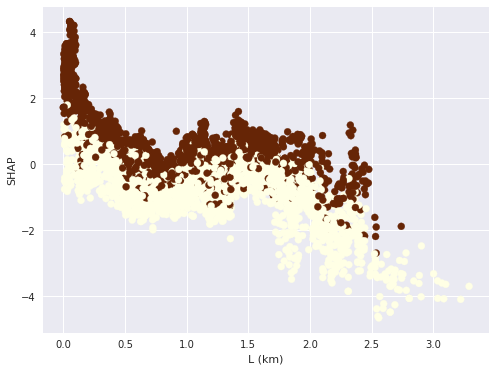

In [68]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(l, l_shap, c=target, cmap='YlOrBr')

    plt.xlabel('L (km)')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

### PGA SHAP values

In [69]:
# GWD datset
pga = shap_values.data[:,4]
pga_shap = shap_values.values[:,4]
pga_shap_dataset = np.array(list(zip(pga, pga_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


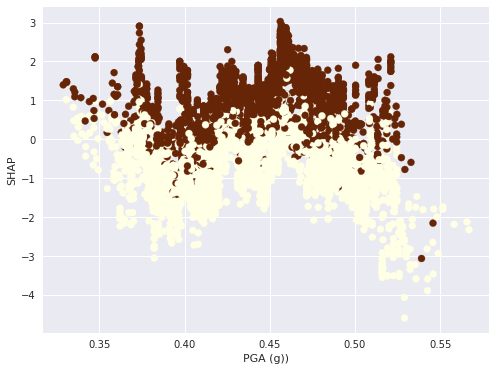

In [70]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pga, pga_shap, c=target, cmap='YlOrBr')

    plt.xlabel('PGA (g))')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

## Slope

In [71]:
# GWD datset
slope = shap_values.data[:,3]
slope_shap = shap_values.values[:,3]
slope_shap_dataset = np.array(list(zip(pga, pga_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


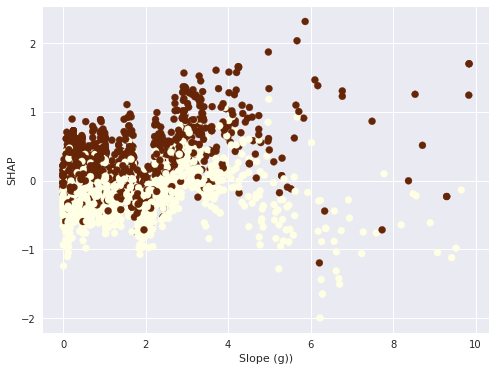

In [72]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(slope, slope_shap, c=target, cmap='YlOrBr')

    plt.xlabel('Slope (g))')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

# PCA

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

xstd = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=3)
pcs = pca.fit_transform(xstd)
pcDf = pd.DataFrame(data = pcs, columns = ['PCA1', 'PCA2', 'PCA3'])
#pcDf = pd.concat([pcDf, target], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


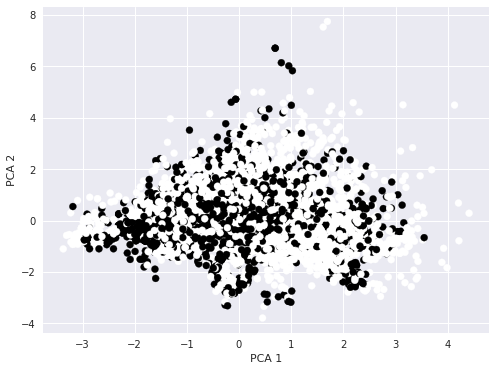

In [74]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA1'], pcDf['PCA2'], c=target)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


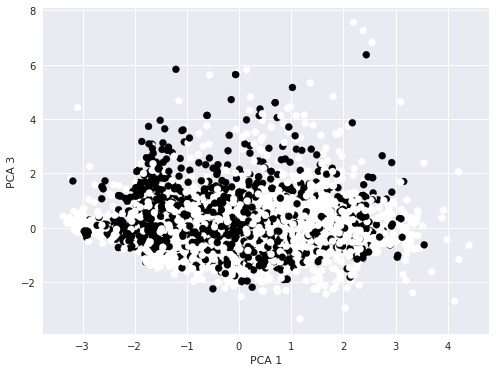

In [75]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA1'], pcDf['PCA3'], c=target)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 3')
    plt.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


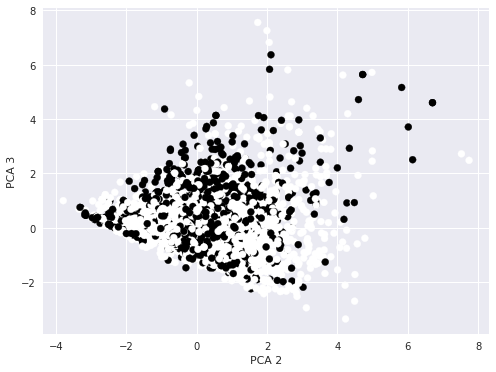

In [76]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA2'], pcDf['PCA3'], c=target)

    plt.xlabel('PCA 2')
    plt.ylabel('PCA 3')
    plt.legend(loc='best')

In [77]:
# Regression fit
pcmodel = xgboost.XGBClassifier().fit(pcDf, target)


[17:58:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [78]:
xstd_test = StandardScaler().fit_transform(X_test)
pca = PCA(n_components=3)
ptestcs = pca.fit_transform(xstd_test)
ptestDf = pd.DataFrame(data = ptestcs, columns = ['PCA1', 'PCA2', 'PCA3'])
xtest_target = X_test_target['Target']

In [79]:
# make prediction
preds = pcmodel.predict(ptestDf)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(xtest_target, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.74%
